In [6]:

import cv2
import copy
import math
import numpy as np
from scipy import ndimage
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr

In [7]:
from matplotlib import pyplot as plt
np.set_printoptions(threshold=np.inf)

# Functions

In [13]:
def read_image(image_path):
    """
    Read an image and convert it in gray scale.
    :param image_path: string, path of image file
    :return: image: ndarray, gray scale image
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # image = cv2.resize(image, (w, h, ))
    return image

In [14]:
def dct_transform(image, mode='compress', dc_free=False):
    """
    Calculate DCT coefficients of an image.
    :param image: ndarray, input image
    :param mode: string, compression or normal mode
    :param dc_free: boolean, option whether DC coefficient is missing
    :return: dct_coefs
    """
    dct_coefs = np.zeros([w_n, h_n, patch_size, patch_size])
    image = image - 128 * np.ones([w, h])
    for i in range(w_n):
        for j in range(h_n):
            image_patch = image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            dct = cv2.dct(image_patch)
            if dc_free:
                dct[0][0] = 0.
            if mode == 'compress':
                dct_coefs[i, j] = np.round(dct / Q)
            elif mode == 'normal':
                dct_coefs[i, j] = dct

    return dct_coefs

In [41]:
def recover_from_dct(dct_coefs, mode='compress'):
    image_rec = np.zeros(image_shape)
    if mode == 'normal':
        for i in range(w_n):
            for j in range(h_n):
                idct = cv2.idct(dct_coefs[i, j])
                image_rec[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = idct + 128
    elif mode == 'compress':
        for i in range(w_n):
            for j in range(h_n):
                idct = cv2.idct(dct_coefs[i, j] * Q)
                if np.min(np.min(idct)) < -128:
                    print(np.min(np.min(idct)))
                image_rec[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = idct + 128

    return image_rec

In [16]:
def estimate_0(dct_target, dct_left=False, dct_up=False, dct_right=False, dct_down=False):
    """
    Estimation of DCT coefficients with the help of adjacent blocks.
    :param dct_target: ndarray, DCT of target block
    :param dct_left: ndarray, DCT of left block
    :param dct_up: ndarray, DCT of upper block
    :param dct_right: ndarray, DCT of right block
    :param dct_down: ndarray, DCT of nether block
    :return: dc_optimal: float, optimal value of DC prediction
    """
    mse_min = np.inf
    dc_optimal = 0.
    if dct_left is not False:
        spatial_left = cv2.idct(dct_left * Q) + 128
    if dct_up is not False:
        spatial_up = cv2.idct(dct_up * Q) + 128
    if dct_right is not False:
        spatial_right = cv2.idct(dct_right * Q) + 128
    if dct_down is not False:
        spatial_down = cv2.idct(dct_down * Q) + 128
    for dc in DC_range:
        mse1 = 0.
        mse2 = 0.
        mse3 = 0.
        dct_target[0, 0] = dc
        spatial_target = cv2.idct(dct_target * Q) + 128
        if dct_left is not False:
            mse1 += np.sum(np.square(spatial_left[0:8, 7] - spatial_target[0:8, 0])) / 8
            mse2 += np.sum(np.square(spatial_left[0:7, 7] - spatial_target[1:8, 0])) / 7
            mse3 += np.sum(np.square(spatial_left[1:8, 7] - spatial_target[0:7, 0])) / 7
        if dct_up is not False:
            mse1 += np.sum(np.square(spatial_up[7, 0:8] - spatial_target[0, 0:8])) / 8
            mse2 += np.sum(np.square(spatial_up[7, 0:7] - spatial_target[0, 1:8])) / 7
            mse3 += np.sum(np.square(spatial_up[7, 1:8] - spatial_target[0, 0:7])) / 7
        if dct_right is not False:
            mse1 += np.sum(np.square(spatial_right[0:8, 0] - spatial_target[0:8, 7])) / 8
            mse2 += np.sum(np.square(spatial_right[0:7, 0] - spatial_target[1:8, 7])) / 7
            mse3 += np.sum(np.square(spatial_right[1:8, 0] - spatial_target[0:7, 7])) / 7
        if dct_down is not False:
            mse1 += np.sum(np.square(spatial_down[0, 0:8] - spatial_target[7, 0:8])) / 8
            mse2 += np.sum(np.square(spatial_down[0, 0:7] - spatial_target[7, 1:8])) / 7
            mse3 += np.sum(np.square(spatial_down[0, 1:8] - spatial_target[7, 0:7])) / 7
        mse = np.min([mse1, mse2, mse3])
        if mse < mse_min:
            mse_min = mse
            dc_optimal = dc

    return dc_optimal

In [17]:
def estimate(dct_target, dct_left=False, dct_up=False, dct_right=False, dct_down=False):
    """
    Estimation of DCT coefficients with the help of adjacent blocks.
    :param dct_target: ndarray, DCT of target block
    :param dct_left: ndarray, DCT of left block
    :param dct_up: ndarray, DCT of upper block
    :param dct_right: ndarray, DCT of right block
    :param dct_down: ndarray, DCT of nether block
    :return: dc_optimal: float, optimal value of DC prediction
    """
    mse_min = np.inf
    dc_optimal = 0.
    if dct_left is not False:
        spatial_left = cv2.idct(dct_left * Q) + 128
    if dct_up is not False:
        spatial_up = cv2.idct(dct_up * Q) + 128
    if dct_right is not False:
        spatial_right = cv2.idct(dct_right * Q) + 128
    if dct_down is not False:
        spatial_down = cv2.idct(dct_down * Q) + 128
    for dc in DC_range:
        mse1 = 0.
        mse2 = 0.
        mse3 = 0.
        dct_target[0, 0] = dc
        spatial_target = cv2.idct(dct_target * Q) + 128
        if dct_left is not False:
            mse1 += np.sum(np.square((spatial_left[0:8, 7] - spatial_target[0:8, 0]) -
                                     (spatial_left[0:8, 6] - spatial_left[0:8, 7]))) / 8
            mse2 += np.sum(np.square((spatial_left[0:7, 7] - spatial_target[1:8, 0]) -
                                     (spatial_left[0:7, 6] - spatial_left[1:8, 7]))) / 7
            mse3 += np.sum(np.square((spatial_left[1:8, 7] - spatial_target[0:7, 0]) -
                                     (spatial_left[1:8, 6] - spatial_left[0:7, 7]))) / 7
        if dct_up is not False:
            mse1 += np.sum(np.square((spatial_up[7, 0:8] - spatial_target[0, 0:8]) -
                                     (spatial_up[6, 0:8] - spatial_up[7, 0:8]))) / 8
            mse2 += np.sum(np.square((spatial_up[7, 0:7] - spatial_target[0, 1:8]) -
                                     (spatial_up[6, 0:7] - spatial_up[7, 1:8]))) / 7
            mse3 += np.sum(np.square((spatial_up[7, 1:8] - spatial_target[0, 0:7]) -
                                     (spatial_up[6, 1:8] - spatial_up[7, 0:7]))) / 7
        if dct_right is not False:
            mse1 += np.sum(np.square((spatial_right[0:8, 0] - spatial_target[0:8, 7]) -
                                     (spatial_right[0:8, 1] - spatial_right[0:8, 0]))) / 8
            mse2 += np.sum(np.square((spatial_right[0:7, 0] - spatial_target[1:8, 7]) -
                                     (spatial_right[0:7, 1] - spatial_right[1:8, 0]))) / 7
            mse3 += np.sum(np.square((spatial_right[1:8, 0] - spatial_target[0:7, 7]) -
                                     (spatial_right[1:8, 1] - spatial_right[0:7, 0]))) / 7
        if dct_down is not False:
            mse1 += np.sum(np.square((spatial_down[0, 0:8] - spatial_target[7, 0:8]) -
                                     (spatial_down[1, 0:8] - spatial_down[0, 0:8]))) / 8
            mse2 += np.sum(np.square((spatial_down[0, 0:7] - spatial_target[7, 1:8]) -
                                     (spatial_down[1, 0:7] - spatial_down[0, 1:8]))) / 7
            mse3 += np.sum(np.square((spatial_down[0, 1:8] - spatial_target[7, 0:7]) -
                                     (spatial_down[1, 1:8] - spatial_down[0, 0:7]))) / 7
        mse = np.min([mse1, mse2, mse3])
        if mse < mse_min:
            mse_min = mse
            dc_optimal = dc

    return dc_optimal

In [18]:
def dc_prediction_1(dct_coefs, dc_preset):
    """
    DC coefficients prediction from up-left to right-down.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[0, 0, 0, 0] = dc_preset
    for i in range(w_n):
        for j in range(h_n):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == 0:
                dct_up = dct_coefs[i - 1, j]
                dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up)
            else:
                dct_left = dct_coefs[i, j - 1]
                dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                if i == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_left=dct_left)
                else:
                    dct_up = dct_coefs[i - 1, j]
                    dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_left=dct_left)
            dct_preds[i, j] = dct_target

    return dct_preds

In [19]:
def dc_prediction_2(dct_coefs, dc_preset):
    """
    DC coefficients prediction from up-right to left-down.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[0, h_n - 1, 0, 0] = dc_preset
    for i in range(w_n):
        for j in np.arange(h_n - 1, -1, -1):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == h_n - 1:
                dct_up = dct_coefs[i - 1, j]
                dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up)
            else:
                dct_right = dct_coefs[i, j + 1]
                dct_right[0, 0] = dct_preds[i, j + 1, 0, 0]
                if i == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_right=dct_right)
                else:
                    dct_up = dct_coefs[i - 1, j]
                    dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_right=dct_right)
            dct_preds[i, j] = dct_target

    return dct_preds

In [20]:
def dc_prediction_3(dct_coefs, dc_preset):
    """
    DC coefficients prediction from left-down to up-right.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[w_n - 1, 0, 0, 0] = dc_preset
    for i in np.arange(w_n - 1, -1, -1):
        for j in range(h_n):
            dct_target = dct_coefs[i, j]
            if i == w_n - 1 and j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == 0:
                dct_down = dct_coefs[i + 1, j]
                dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down)
            else:
                dct_left = dct_coefs[i, j - 1]
                dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                if i == w_n - 1:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_left=dct_left)
                else:
                    dct_down = dct_coefs[i + 1, j]
                    dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down, dct_left=dct_left)
            dct_preds[i, j] = dct_target

    return dct_preds

In [21]:
def dc_prediction_4(dct_coefs, dc_preset):
    """
    DC coefficients prediction from right-down to up-left.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[w_n - 1, h_n - 1, 0, 0] = dc_preset
    for i in np.arange(w_n - 1, -1, -1):
        for j in np.arange(h_n - 1, -1, -1):
            dct_target = dct_coefs[i, j]
            if i == w_n - 1 and j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == h_n - 1:
                dct_down = dct_coefs[i + 1, j]
                dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down)
            else:
                dct_right = dct_coefs[i, j + 1]
                dct_right[0, 0] = dct_preds[i, j + 1, 0, 0]
                if i == w_n - 1:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_right=dct_right)
                else:
                    dct_down = dct_coefs[i + 1, j]
                    dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down, dct_right=dct_right)
            dct_preds[i, j] = dct_target

    return dct_preds

In [22]:
def dc_prediction_5(dct_coefs, dc_preset):
    """
    DC coefficients prediction from right-down to up-left.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[0, 0, 0, 0] = dc_preset
    for j in np.arange(h_n):
        for i in np.arange(w_n):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if i == 0:
                dct_left = dct_coefs[i, j - 1]
                dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_left=dct_left)
            else:
                dct_up = dct_coefs[i - 1, j]
                dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                if j == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up)
                else:
                    dct_left = dct_coefs[i, j - 1]
                    dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_left=dct_left)
            dct_preds[i, j] = dct_target

    return dct_preds

In [23]:
def dc_prediction_6(dct_coefs, dc_preset):
    """
    DC coefficients prediction from right-down to up-left.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[w_n - 1, h_n - 1, 0, 0] = dc_preset
    for i in np.arange(w_n - 1, -1, -1):
        for j in np.arange(h_n - 1, -1, -1):
            dct_target = dct_coefs[i, j]
            if i == w_n - 1 and j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == h_n - 1:
                dct_down = dct_coefs[i + 1, j]
                dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down)
            else:
                dct_right = dct_coefs[i, j + 1]
                dct_right[0, 0] = dct_preds[i, j + 1, 0, 0]
                if i == w_n - 1:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_right=dct_right)
                else:
                    dct_down = dct_coefs[i + 1, j]
                    dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down, dct_right=dct_right)
            dct_preds[i, j] = dct_target

    return dct_preds

In [24]:
def dc_prediction_7(dct_coefs, dc_preset):
    """
    DC coefficients prediction from right-down to up-left.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[w_n - 1, h_n - 1, 0, 0] = dc_preset
    for i in np.arange(w_n - 1, -1, -1):
        for j in np.arange(h_n - 1, -1, -1):
            dct_target = dct_coefs[i, j]
            if i == w_n - 1 and j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == h_n - 1:
                dct_down = dct_coefs[i + 1, j]
                dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down)
            else:
                dct_right = dct_coefs[i, j + 1]
                dct_right[0, 0] = dct_preds[i, j + 1, 0, 0]
                if i == w_n - 1:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_right=dct_right)
                else:
                    dct_down = dct_coefs[i + 1, j]
                    dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down, dct_right=dct_right)
            dct_preds[i, j] = dct_target

    return dct_preds

In [25]:
def dc_prediction_8(dct_coefs, dc_preset):
    """
    DC coefficients prediction from right-down to up-left.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[w_n - 1, h_n - 1, 0, 0] = dc_preset
    for i in np.arange(w_n - 1, -1, -1):
        for j in np.arange(h_n - 1, -1, -1):
            dct_target = dct_coefs[i, j]
            if i == w_n - 1 and j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == h_n - 1:
                dct_down = dct_coefs[i + 1, j]
                dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down)
            else:
                dct_right = dct_coefs[i, j + 1]
                dct_right[0, 0] = dct_preds[i, j + 1, 0, 0]
                if i == w_n - 1:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_right=dct_right)
                else:
                    dct_down = dct_coefs[i + 1, j]
                    dct_down[0, 0] = dct_preds[i + 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_down=dct_down, dct_right=dct_right)
            dct_preds[i, j] = dct_target

    return dct_preds

In [26]:
def dc_recovery(image_path):
    """
    Recover image from four corners.
    :param image_path: string, path of image file
    :return: dct_preds: ndarray, predicted DCT coefficients of blocks
             image_rec: ndarray, recovered image
    """
    image = read_image(image_path)
    dct_coefs = dct_transform(image, mode='compress', dc_free=True)
    dct_coefs_corner = dct_transform(image, mode='compress', dc_free=False)
    dc_preset = [dct_coefs_corner[0, 0, 0, 0], dct_coefs_corner[0, h_n - 1, 0, 0],
                 dct_coefs_corner[w_n - 1, 0, 0, 0], dct_coefs_corner[w_n - 1, h_n - 1, 0, 0]]
    dct_preds = dc_prediction_1(dct_coefs, dc_preset[0])
    dct_preds += dc_prediction_2(dct_coefs, dc_preset[1])
    dct_preds += dc_prediction_3(dct_coefs, dc_preset[2])
    dct_preds += dc_prediction_4(dct_coefs, dc_preset[3])
    dct_preds /= 4.
    image_rec = recover_from_dct(dct_preds, mode='compress')

    return dct_preds, image_rec

# Initialisation

In [27]:
# Initialisation
patch_size = 8
image_shape = (256, 256)
[w, h] = image_shape
w_n = w // patch_size
h_n = h // patch_size
DC_range = np.arange(-64, 65)
# Quantization matrix
Q = [[16, 11, 10, 16, 24, 40, 51, 61],
     [12, 12, 14, 19, 26, 58, 60, 55],
     [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62],
     [18, 22, 37, 56, 68, 109, 103, 77],
     [24, 35, 55, 64, 81, 104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 130, 99]]

In [54]:
image_path = "../dataset/girlface.jpg"
image = read_image(image_path)
dct_coefs = dct_transform(image, mode='compress', dc_free=True)
dct_coefs_true = dct_transform(image, mode='compress', dc_free=False)
dc_preset = [dct_coefs_true[0, 0, 0, 0], dct_coefs_true[0, h_n - 1, 0, 0],
             dct_coefs_true[w_n - 1, 0, 0, 0], dct_coefs_true[w_n - 1, h_n - 1, 0, 0]]

# Visualisation

In [34]:
def show_block(image):
    plt.figure(figsize = (12, 12))
    plt.imshow(image, cmap='gray')
    plt.xticks([8 * i for i in range(1, 32)])
    plt.yticks([8 * i for i in range(1, 32)])
    # plt.grid(color='r', linestyle='-', linewidth=1)

In [56]:
def show_dc_diff(dct_coefs, dct_preds):
    dc_diff = np.abs(dct_coefs[:, :, 0, 0] - dct_preds[:, :, 0, 0])
    plt.figure(figsize = (12, 12))
    plt.xticks([i for i in range(32)])
    plt.yticks([i for i in range(32)])
    plt.imshow(dc_diff, cmap='hot_r')
    plt.colorbar()

In [41]:
dct_preds_1 = dc_prediction_1(dct_coefs, dc_preset[0])
image_rec_1 = recover_from_dct(dct_preds_1, mode='compress')

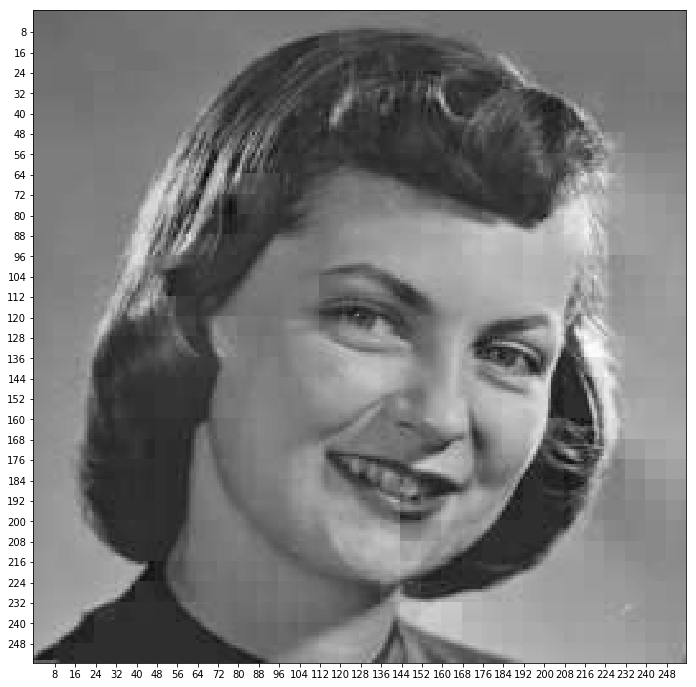

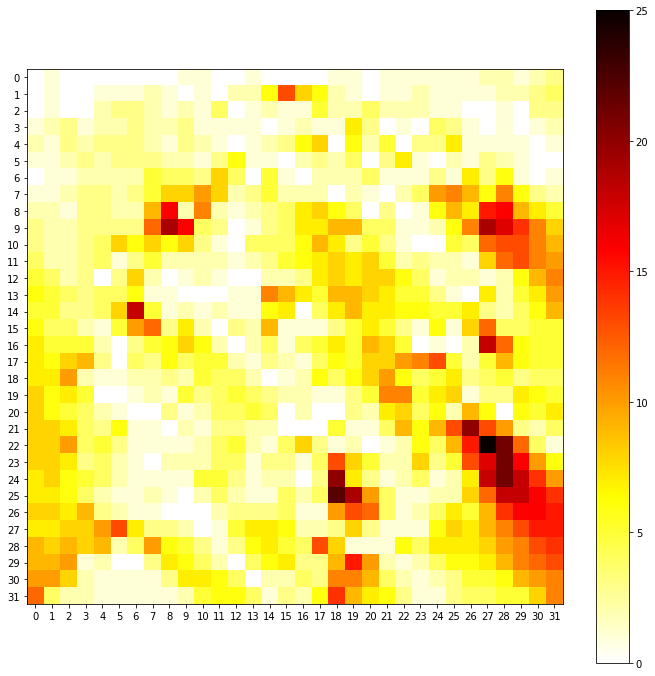

In [69]:
show_block(image_rec_1)
show_dc_diff(dct_coefs_true, dct_preds_1)

In [59]:
dct_preds_2 = dc_prediction_2(dct_coefs, dc_preset[1])
image_rec_2 = recover_from_dct(dct_preds_2, mode='compress')

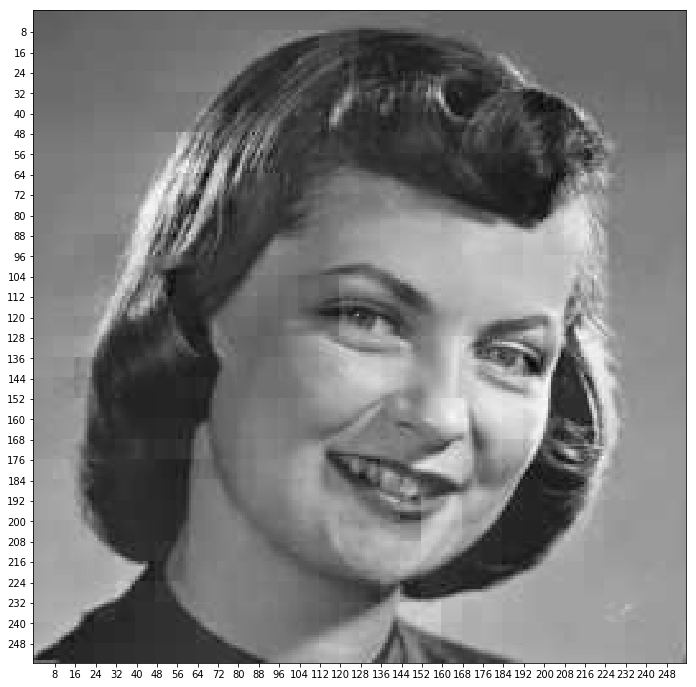

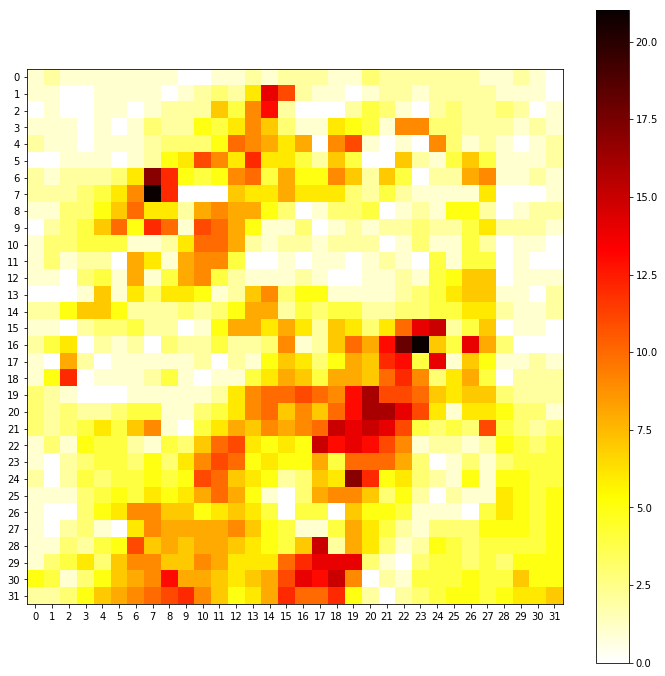

In [68]:
show_block(image_rec_2)
show_dc_diff(dct_coefs_true, dct_preds_2)

In [61]:
dct_preds_3 = dc_prediction_3(dct_coefs, dc_preset[2])
image_rec_3 = recover_from_dct(dct_preds_3, mode='compress')

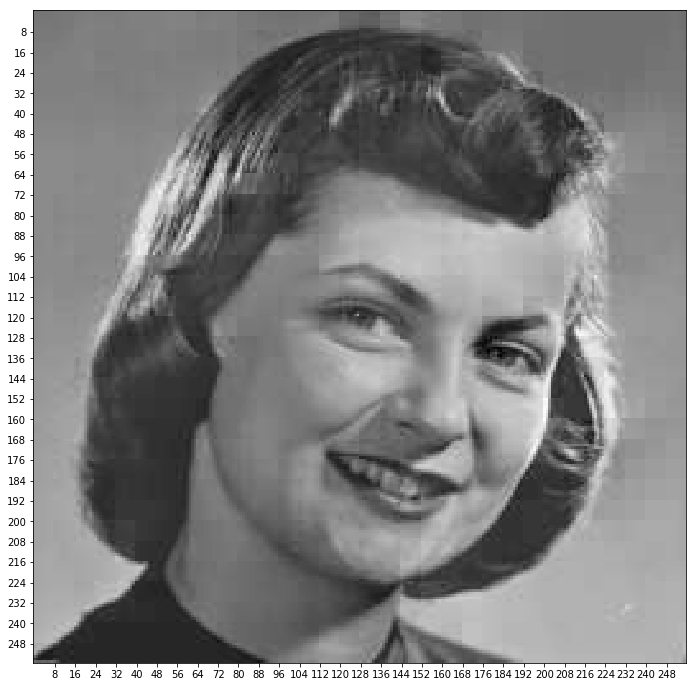

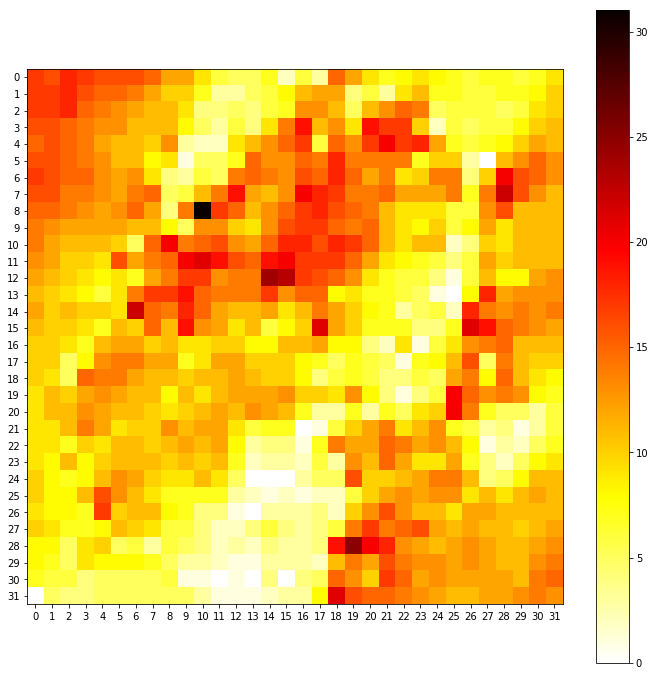

In [67]:
show_block(image_rec_3)
show_dc_diff(dct_coefs_true, dct_preds_3)

In [64]:
dct_preds_4 = dc_prediction_4(dct_coefs, dc_preset[3])
image_rec_4 = recover_from_dct(dct_preds_4, mode='compress')

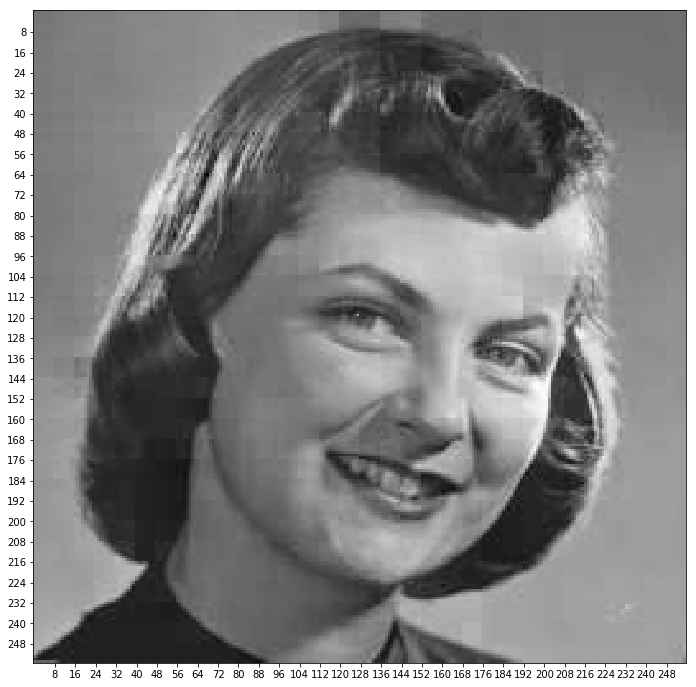

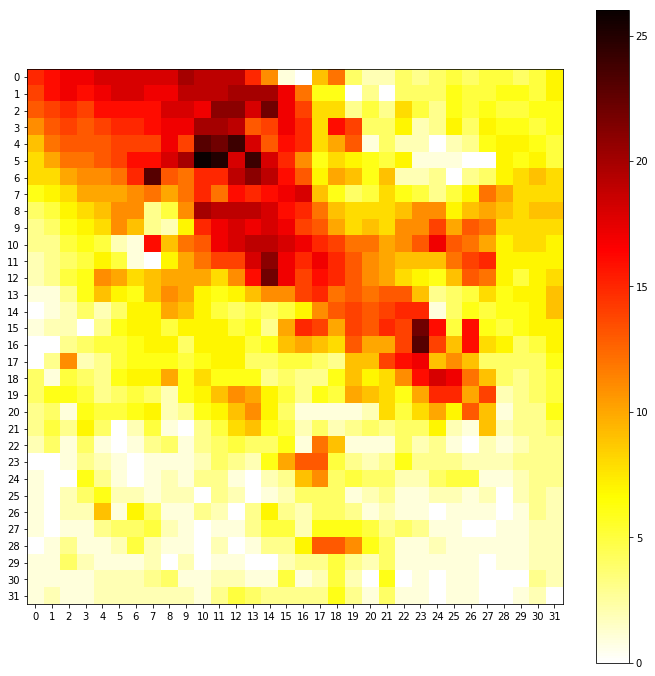

In [66]:
show_block(image_rec_4)
show_dc_diff(dct_coefs_true, dct_preds_4)

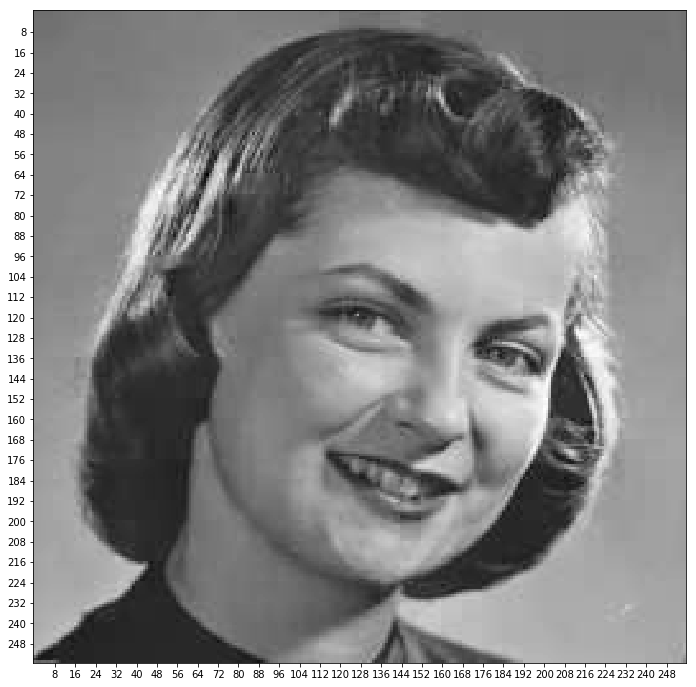

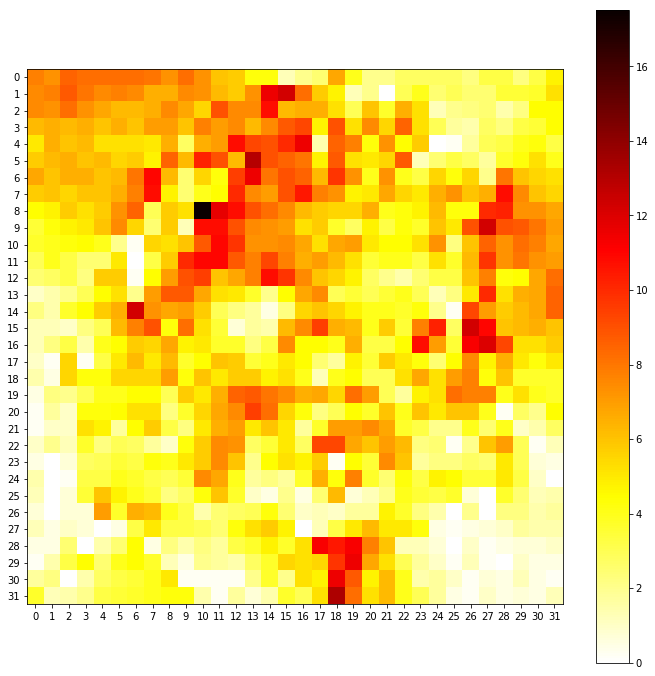

In [108]:
dct_preds_average, image_rec_average = dc_recovery("../dataset/girlface.jpg")
show_block(image_rec_average)
show_dc_diff(dct_coefs_true, dct_preds_average)

In [ ]:
def dc_recovery(image_path):
    """
    Recover image from four corners.
    :param image_path: string, path of image file
    :return: dct_preds: ndarray, predicted DCT coefficients of blocks
             image_rec: ndarray, recovered image
    """
    image = read_image(image_path)
    dct_coefs = dct_transform(image, mode='compress', dc_free=True)
    dct_coefs_corner = dct_transform(image, mode='compress', dc_free=False)
    dc_preset = [dct_coefs_corner[0, 0, 0, 0], dct_coefs_corner[0, h_n - 1, 0, 0],
                 dct_coefs_corner[w_n - 1, 0, 0, 0], dct_coefs_corner[w_n - 1, h_n - 1, 0, 0]]
    dct_preds = dc_prediction_1(dct_coefs, dc_preset[0])
    dct_preds += dc_prediction_2(dct_coefs, dc_preset[1])
    dct_preds += dc_prediction_3(dct_coefs, dc_preset[2])
    dct_preds += dc_prediction_4(dct_coefs, dc_preset[3])
    dct_preds /= 4.
    image_rec = recover_from_dct(dct_preds, mode='compress')

    return dct_preds, image_rec

In [ ]:
dct_preds_selected = np.zeros((32, 32, 8, 8))
for i in range(w_n):
    for j in range(h_n):
        
        dct_preds_selected = 

# Initialisation
patch_size = 8
image_shape = (4032, 3024)
[w, h] = image_shape
w_n = w // patch_size
h_n = h // patch_size
_, image_rec = dc_recovery("../dataset/challenge1.jpg")
show_block(image_rec)

# Initialisation
patch_size = 8
image_shape = (512, 512)
[w, h] = image_shape
w_n = w // patch_size
h_n = h // patch_size
_, image_rec = dc_recovery("../dataset/bar.bmp")
show_block(image_rec)

# Remaining one column

In [101]:
patch_size = 8
image_shape = (256, 256)
[w, h] = image_shape
w_n = w // patch_size
h_n = h // patch_size

In [102]:
def dc_prediction_1_mode_1(dct_coefs, dc_preset):
    """
    DC coefficients prediction from up-left to right-down.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[:, 0, 0, 0] = dc_preset
    for i in range(w_n):
        for j in range(h_n):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
            else:
                dct_left = dct_coefs[i, j - 1]
                dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                if i == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_left=dct_left)
                else:
                    dct_up = dct_coefs[i - 1, j]
                    dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_left=dct_left)
            dct_preds[i, j] = dct_target

    return dct_preds

In [105]:
dct_preds_1_mode_1 = dc_prediction_1_mode_1(dct_coefs, dc_preset=dct_coefs_true[:, 0, 0, 0])
image_rec_1_mode_1 = recover_from_dct(dct_preds_1_mode_1, mode='compress')

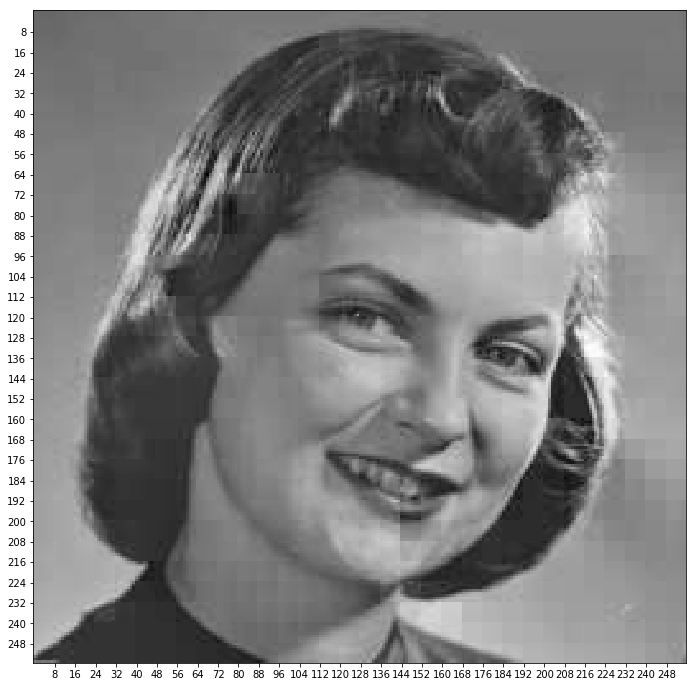

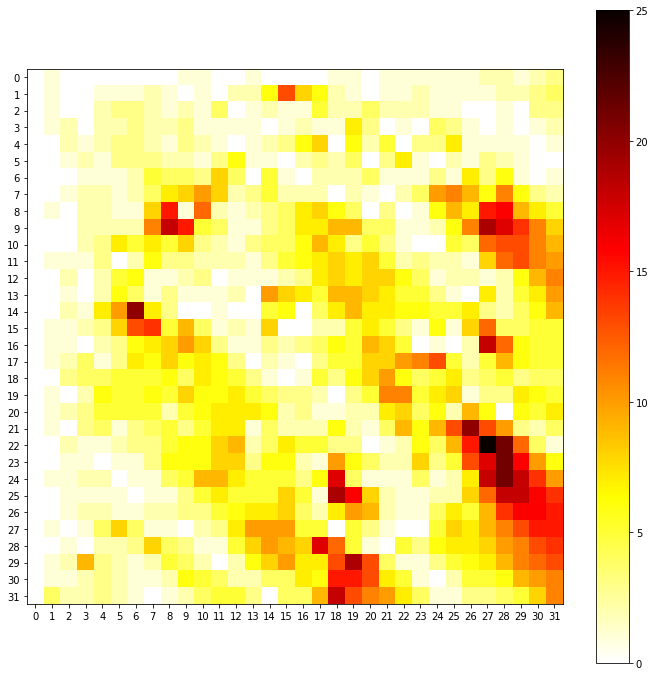

In [107]:
show_block(image_rec_1_mode_1)
show_dc_diff(dct_coefs_true, dct_preds_1_mode_1)

In [109]:
def dc_prediction_2_mode_1(dct_coefs, dc_preset):
    """
    DC coefficients prediction from up-right to left-down.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[:, h_n - 1, 0, 0] = dc_preset
    for i in range(w_n):
        for j in np.arange(h_n - 1, -1, -1):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == h_n - 1:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
            else:
                dct_right = dct_coefs[i, j + 1]
                dct_right[0, 0] = dct_preds[i, j + 1, 0, 0]
                if i == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_right=dct_right)
                else:
                    dct_up = dct_coefs[i - 1, j]
                    dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_right=dct_right)
            dct_preds[i, j] = dct_target

    return dct_preds

In [110]:
dct_preds_2_mode_1 = dc_prediction_2_mode_1(dct_coefs, dc_preset=dct_coefs_true[:, h_n - 1, 0, 0])
image_rec_2_mode_1 = recover_from_dct(dct_preds_2_mode_1, mode='compress')

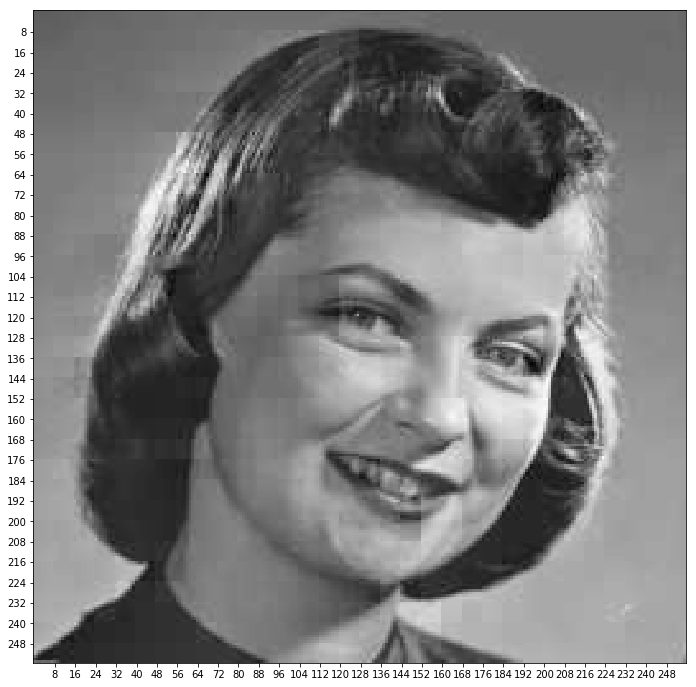

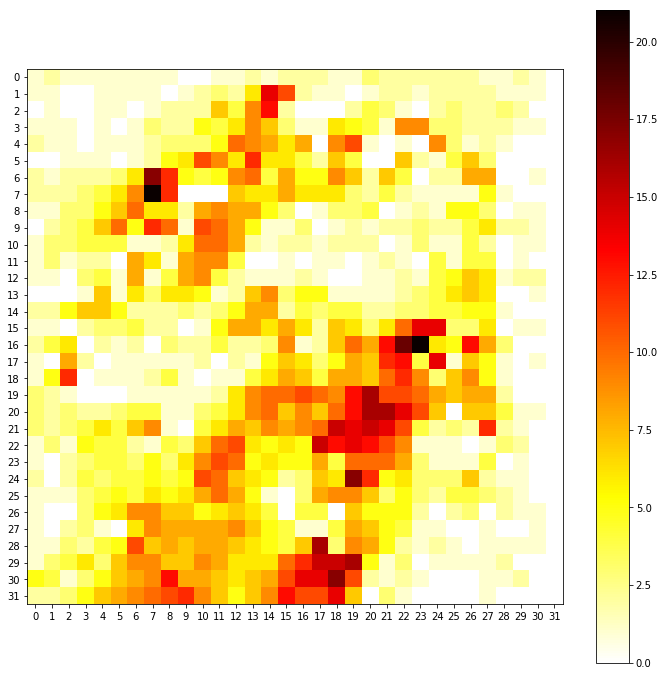

In [111]:
show_block(image_rec_2_mode_1)
show_dc_diff(dct_coefs_true, dct_preds_2_mode_1)

In [121]:
def dc_prediction_5_mode_1(dct_coefs, dc_preset):
    """
    DC coefficients prediction from right-down to up-left.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[0, :, 0, 0] = dc_preset
    for j in np.arange(h_n):
        for i in np.arange(w_n):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if i == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
            else:
                dct_up = dct_coefs[i - 1, j]
                dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                if j == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up)
                else:
                    dct_left = dct_coefs[i, j - 1]
                    dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_left=dct_left)
            dct_preds[i, j] = dct_target

    return dct_preds

In [122]:
dct_preds_5_mode_1 = dc_prediction_5_mode_1(dct_coefs, dc_preset=dct_coefs_true[0, :, 0, 0])
image_rec_5_mode_1 = recover_from_dct(dct_preds_5_mode_1, mode='compress')

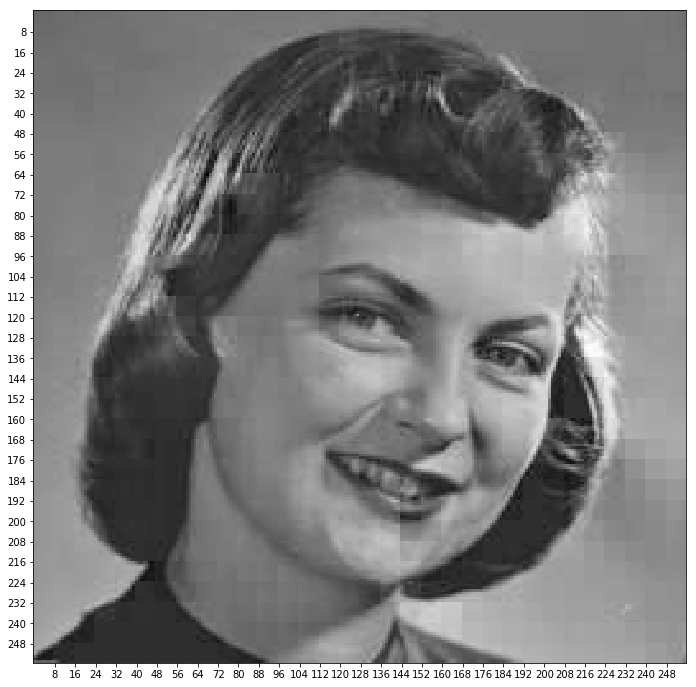

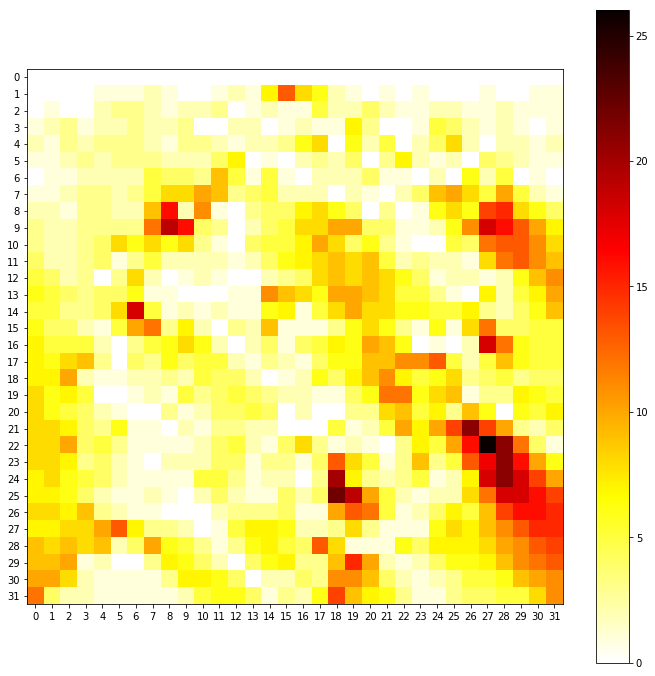

In [123]:
show_block(image_rec_5_mode_1)
show_dc_diff(dct_coefs_true, dct_preds_5_mode_1)

In [50]:
image = cv2.imread("../image/10.jpg", 0)

In [51]:
dct = dct_transform(image, dc_free=True)

In [52]:
image_rec = recover_from_dct(dct)

-165.51017854479926
-173.6908579374139


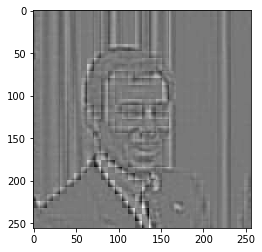

In [33]:
plt.imshow(image_rec, cmap='gray')

In [34]:
image_rec

array([[138.50991477, 137.16186628, 135.06165729, 133.08150203,
        131.91352102, 131.73552878, 132.18396318, 132.63807771,
        147.24517785, 144.63202035, 139.80353488, 133.49481459,
        126.66630495, 120.35758466, 115.52909919, 112.91594168,
        113.18991776, 116.46943302, 122.11441035, 128.6788703 ,
        134.74865665, 139.39969944, 142.33869627, 143.70479436,
        147.99905544, 146.71861342, 143.52311168, 137.72587071,
        129.37991449, 119.75583919, 111.14837645, 106.04110012,
        101.74683904, 106.7684593 , 115.63242694, 126.40270042,
        137.02482653, 145.88168284, 152.03966999, 155.14787308,
        151.87081289, 145.7211719 , 136.01722381, 126.58263812,
        120.51285177, 118.73193472, 119.85190864, 121.35593629,
        113.29329851, 120.51872838, 129.482472  , 134.65475257,
        135.3055892 , 134.73761829, 135.5834204 , 137.06859879,
        128.        , 128.        , 128.        , 128.        ,
        128.        , 128.        , 128.

In [57]:
a = np.load("../data_np/image_dcfree_5000.npy")

In [60]:
np.max(a)

373.6004194987728

In [59]:
a.shape

(5000, 256, 256, 1)

In [61]:
b = np.load("../data_np/dcfree_image_crop.npy")

In [62]:
b.shape

(1125000, 32, 32, 1)

In [63]:
np.min(b)

-83

In [64]:
np.max(b)

373